In [ ]:
import os
from pathlib import Path
from typing import Dict, List, Optional, Sequence, Tuple

import numpy as np
import pandas as pd
from sklearn.metrics import log_loss, roc_auc_score



# Paths: important to adjust as needed
# Returns matrix (daily x permno)
RETURNS_H5 = Path("data/returns_matrix_core_stocks.h5")  # <- set to your file if different
RETURNS_KEY = "returns_matrix_core_stocks"

# Per-name EWMA(63) sigma
SIGMA_H5 = Path("features/ewma_std_span_63_core_stocks.h5")  # uploaded path
SIGMA_KEY = "ewma_std_span_63_core_stocks"

# Scores panel with net_score_test_3d_wa and dates/permno
BACKTEST_H5 = 'YOUR_BACKTEST_PATH'
BACKTEST_KEY = "YOUR_BACKTEST_KEY"

# Optional outputs (set OUT_DIR=None to disable saving)
OUT_DIR = Path("results_enhanced")
OUT_SUMMARY_CSV = OUT_DIR / "enhanced_summary_by_split.csv" if OUT_DIR is not None else None
OUT_OOS_CSV = OUT_DIR / "enhanced_oos_series.csv" if OUT_DIR is not None else None

# --- Strategy settings ---
PRED_COL = "net_score_test_3d_wa"   # score used for ranking
COL_TO_DROP_NA_BY = "net_score_test"  # column used to drop rows with missing scores

# Selection rules
LONG_FRAC = 0.10 # top/bottom decile per side
MIN_UNIVERSE = 20 # minimum names needed at a rebalance

# Per-name risk scaling at entry
SIGMA_TGT_PER_NAME = 0.00945
MIN_ACCEPTABLE_STD = 1e-3

# Portfolio-level vol targeting after L+S
SIGMA_TGT_PORT = 0.00945
EWMA_SPAN = 63
SIGMA_MIN = 1e-4
LEVERAGE_CAP: Optional[float] = None  # e.g., 3.0

# EWMA behavior on days with no positions/PnL
EWMA_IGNORE_ZERO_RETURNS = True
EWMA_ZERO_EPS = 0.0

# Burn-in for test volatility when a split starts cold
BURNIN_K = 252

# Train/Test windows (fixed)
TRAIN_TEST_LSTS: List[Tuple[Tuple[str, str], Tuple[str, str]]] = [
    (("1999-01-01", "2004-11-25"), ("2004-12-01", "2009-11-30")),
    (("1999-01-01", "2009-11-25"), ("2009-12-01", "2014-11-30")),
    (("1999-01-01", "2014-11-25"), ("2014-12-01", "2019-11-30")),
    (("1999-01-01", "2019-11-25"), ("2019-12-01", "2024-12-31")),
]

# Grid for tuning the magnitude exponent p on the train window.
# Use [0] for equal-weight baseline, swap to linspace(...) for flexi-p.
P_GRID = np.linspace(0, 1, 21)
P_GRID = [0]

# Create output dir if enabled
if OUT_DIR is not None:
    OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Optional beta hedge vs SPY ---
ENABLE_BETA_HEDGING = True

# Per-name monthly SPY betas: EOM index, permno columns (ints)
BETA_H5 = Path("features/beta_df_core_stocks.h5")
BETA_KEY = "beta_df_core_stocks"

# Daily SPY returns (decimal), columns: ['date', 'SPY']
SPY_RET_CSV = Path("features/spy_vix_changes.csv")

# Optional OOS series for the hedged book
OUT_OOS_HEDGED_CSV = OUT_DIR / "enhanced_oos_series_hedged.csv" if OUT_DIR is not None else None

# --- Transaction costs ---
# One-way bps paid on stock legs at monthly rebalance
ONE_WAY_TC_BPS = 5.0  # 5 bps = 0.0005 per $ traded

# Hedge TC settings for SPY overlay; ignored if INCLUDE_HEDGE_TC=False
INCLUDE_HEDGE_TC = False
HEDGE_ONE_WAY_TC_BPS = 1.0

In [ ]:
def last_trading_days(index: pd.DatetimeIndex) -> pd.DatetimeIndex:
    if not isinstance(index, pd.DatetimeIndex):
        index = pd.to_datetime(index)
        
    index = pd.DatetimeIndex(index).sort_values().unique()
    periods = index.to_period("M")
    s = pd.Series(periods, index=index)
    return index[s.ne(s.shift(-1)).values]

def sharpe_ratio(x: np.ndarray) -> float:
    x = np.asarray(x, float)
    if x.size < 3:
        return np.nan
    mu = float(np.nanmean(x))
    sd = float(np.nanstd(x, ddof=1))
    if not np.isfinite(sd) or sd <= 0:
        return np.nan
    return mu / sd * np.sqrt(252.0)

def ewma_sigma_path(
    r: np.ndarray,
    span: int = EWMA_SPAN,
    init_sigma: Optional[float] = None,
    *,
    ignore_zeros: bool = EWMA_IGNORE_ZERO_RETURNS,
    zero_eps: float = EWMA_ZERO_EPS,
) -> np.ndarray:
    r = np.asarray(r, float)
    n = r.size
    if n == 0:
        return np.array([], dtype=float)
    alpha = 2.0 / (span + 1.0)
    lam = 1.0 - alpha
    sig = np.empty(n, float)
    if init_sigma is None:
        k = int(min(63, max(1, n)))
        s0 = float(np.nanstd(r[:k], ddof=1)) if k >= 2 else SIGMA_TGT_PORT
        if not np.isfinite(s0) or s0 <= 0:
            s0 = SIGMA_TGT_PORT
        sig[0] = s0
    else:
        sig[0] = float(init_sigma)
    v = sig[0] ** 2
    for t in range(1, n):
        rt_1 = float(r[t - 1])
        if ignore_zeros and abs(rt_1) <= zero_eps:
            sig[t] = float(np.sqrt(max(v, 0.0)))
            continue
        v = lam * v + (1.0 - lam) * (rt_1 ** 2)
        sig[t] = float(np.sqrt(max(v, 0.0)))
    return sig

def ewma_sigma_path_with_burnin(
    r: np.ndarray,
    span: int = EWMA_SPAN,
    burnin_days: int = BURNIN_K,
    init_sigma: float = SIGMA_TGT_PORT,
    *,
    ignore_zeros: bool = EWMA_IGNORE_ZERO_RETURNS,
    zero_eps: float = EWMA_ZERO_EPS,
) -> np.ndarray:
    r = np.asarray(r, float)
    n = r.size
    sig = np.empty(n, float)
    if n == 0:
        return sig
    sig[:] = init_sigma
    if n <= burnin_days:
        return sig
    s0 = float(np.nanstd(r[:burnin_days], ddof=1))
    if not np.isfinite(s0) or s0 <= 0:
        s0 = init_sigma
    sig[burnin_days] = s0
    alpha = 2.0 / (span + 1.0)
    lam = 1.0 - alpha
    v = s0 * s0
    for t in range(burnin_days + 1, n):
        rt_1 = float(r[t - 1])
        if ignore_zeros and abs(rt_1) <= zero_eps:
            sig[t] = float(np.sqrt(max(v, 0.0)))
            continue
        v = lam * v + (1.0 - lam) * (rt_1 ** 2)
        sig[t] = float(np.sqrt(max(v, 0.0)))
    return sig

def leverage_series_from_month_first_sig(
    idx: pd.Index,
    sigma_path: np.ndarray,
    sigma_tgt_by_day: float = SIGMA_TGT_PORT,
    sigma_min: float = SIGMA_MIN,
    cap: Optional[float] = LEVERAGE_CAP,
) -> np.ndarray:
    i = np.arange(len(idx))
    months = pd.DatetimeIndex(idx).to_period("M")
    first_pos_each_day = pd.Series(i, index=months).groupby(level=0).transform("min").to_numpy()
    sig_first = np.asarray(sigma_path, float)[first_pos_each_day]
    sig_first = np.maximum(sig_first, sigma_min)
    lev = float(sigma_tgt_by_day) / sig_first
    if cap is not None:
        lev = np.minimum(lev, cap)
    return lev.astype(float)

def basket_returns_between(returns: pd.DataFrame,
                           names: pd.Index,
                           weights: pd.Series,
                           start_excl: pd.Timestamp,
                           end_incl: pd.Timestamp) -> pd.Series:
    if len(names) == 0 or weights.empty:
        return pd.Series(0.0, index=returns.loc[(returns.index > start_excl) & (returns.index <= end_incl)].index)
    sub = returns.loc[(returns.index > start_excl) & (returns.index <= end_incl), names]
    sub = sub.reindex(columns=weights.index).fillna(0.0)
    return (sub * weights.values).sum(axis=1)

def first_trading_days(index: pd.DatetimeIndex) -> pd.DatetimeIndex:
    """First trading day of each month within the provided index (sorted & unique)."""
    if not isinstance(index, pd.DatetimeIndex):
        index = pd.to_datetime(index)
    idx = pd.DatetimeIndex(index).sort_values().unique()
    periods = idx.to_period("M")
    s = pd.Series(periods, index=idx)
    return idx[s.ne(s.shift(1)).values]

def _one_way_rate(one_way_bps: float) -> float:
    """Convert one-way bps to a decimal rate per $ traded."""
    return float(one_way_bps) * 1e-4

def cost_series_from_weights(
    weights_book: Dict[pd.Timestamp, Dict[str, pd.Series]],
    idx: pd.DatetimeIndex,
    lev_series: pd.Series | np.ndarray,
    *,
    one_way_bps: float,
) -> pd.Series:
    """
    Transaction costs for STOCK legs, charged on the first trading day of each month.
    Cost_t0 = c * sum( |lev_t0*w_new - lev_prev*w_prev| ) across L and S.
    Starts flat before the first encountered month.
    """
    if isinstance(lev_series, pd.Series):
        lev = lev_series.reindex(idx).astype(float)
    else:
        arr = np.asarray(lev_series).ravel()
        if len(arr) == 1:
            lev = pd.Series(arr[0], index=idx, name="lev", dtype=float)
        elif len(arr) == len(idx):
            lev = pd.Series(arr, index=idx, name="lev", dtype=float)
        else:
            raise ValueError(f"leverage_series length {len(arr)} doesn't match index length {len(idx)}")

    c = _one_way_rate(one_way_bps)
    cost = pd.Series(0.0, index=idx, name="tcost")
    month_firsts = first_trading_days(idx)

    prev_L = pd.Series(dtype=float)
    prev_S = pd.Series(dtype=float)
    prev_lev = 0.0

    for t0 in month_firsts:
        rec = weights_book.get(t0, None)
        wL_new = rec["L"] if rec is not None else pd.Series(dtype=float)
        wS_new = rec["S"] if rec is not None else pd.Series(dtype=float)
        lev_new = float(lev.loc[t0])

        iL = prev_L.index.union(wL_new.index)
        iS = prev_S.index.union(wS_new.index)

        dL = np.abs(lev_new * wL_new.reindex(iL, fill_value=0.0).values
                    - prev_lev * prev_L.reindex(iL, fill_value=0.0).values).sum()
        dS = np.abs(lev_new * wS_new.reindex(iS, fill_value=0.0).values
                    - prev_lev * prev_S.reindex(iS, fill_value=0.0).values).sum()

        cost.loc[t0] = c * (dL + dS)
        prev_L, prev_S, prev_lev = wL_new, wS_new, lev_new

    return cost

def cost_series_from_hedges(
    hedge_ratios: pd.DataFrame,  # columns ['L','S'], daily (typically month-constant)
    *,
    one_way_bps: float,
) -> pd.Series:
    """
    Transaction costs for SPY overlay, paid when exposure changes.
    Uses c * |Δexposure| across L and S. With month-constant ratios, triggers on first-of-month.
    """
    if hedge_ratios.empty:
        return pd.Series(0.0, index=hedge_ratios.index, name="tcost_hedge")

    c = _one_way_rate(one_way_bps)
    hr = hedge_ratios[["L", "S"]].astype(float)
    delta = hr.diff().abs().sum(axis=1).fillna(hr.iloc[0].abs().sum())
    return (c * delta).rename("tcost_hedge")


In [ ]:
def leg_beta_exposure_at_eom(beta_row: pd.Series, weights: pd.Series) -> float:
    """
    Dot product of per-name weights with per-name SPY betas on the rebalance date.
    Missing betas => 0.
    """
    if weights.empty:
        return 0.0
    b = beta_row.reindex(weights.index).fillna(0.0).astype(float)
    return float(np.nansum(weights.values * b.values))

def hedged_legs_after_leverage(
    base_df: pd.DataFrame,
    leg_betas_df: pd.DataFrame,
    spy_ret_df: pd.DataFrame,
    leverage_series: pd.Series | np.ndarray
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Apply beta hedges AFTER portfolio leverage, per leg.
    Returns (hedged_legs_df, hedge_ratio_df). Both aligned to base_df.index.
    """
    idx = base_df.index
    betas = leg_betas_df.reindex(idx).astype(float).fillna(0.0)
    spy = spy_ret_df.reindex(idx)["SPY"].astype(float).fillna(0.0)

    if isinstance(leverage_series, pd.Series):
        lev = leverage_series.reindex(idx).astype(float)
    else:
        arr = np.asarray(leverage_series).ravel()
        if len(arr) == 1:
            lev = pd.Series(arr[0], index=idx, name="lev", dtype=float)
        elif len(arr) == len(idx):
            lev = pd.Series(arr, index=idx, name="lev", dtype=float)
        else:
            raise ValueError(f"leverage_series length {len(arr)} doesn't match index length {len(idx)}")

    # Levered unhedged legs
    L_lev = base_df["L"].astype(float) * lev
    S_lev = base_df["S"].astype(float) * lev

    # Hedge overlays sized to levered leg betas
    hedge_L = betas["L"] * lev
    hedge_S = betas["S"] * lev

    hedged = pd.DataFrame({
        "L_hedged": L_lev - hedge_L * spy,
        "S_hedged": S_lev - hedge_S * spy
    }, index=idx)

    hedge_ratios = pd.DataFrame({"L": hedge_L, "S": hedge_S}, index=idx)
    return hedged, hedge_ratios


In [20]:
def cs_zscore(s: pd.Series, winsor: float = 3.0) -> pd.Series:
    s = s.astype(float)
    mu = s.mean()
    sd = s.std(ddof=1)
    if not np.isfinite(sd) or sd <= 0:
        return pd.Series(0.0, index=s.index, dtype=float)
    z = (s - mu) / sd
    if np.isfinite(winsor) and winsor > 0:
        z = z.clip(-winsor, winsor)
    return z

def amps_from_scores(scores: pd.Series,
                     p: float = 1.0,
                     winsor: float = 3.0) -> pd.Series:
    """
    Non-negative multipliers proportional to |z|^p.
    p=0 reproduces equal-by-name within-leg.
    """
    z = cs_zscore(scores, winsor=winsor).abs()
    amp = (z ** float(p)).astype(float)
    if not np.isfinite(amp).any() or amp.sum() <= 0:
        amp[:] = 1.0
    return amp

def make_leg_weights(sigmas: pd.Series,
                     scores: pd.Series,
                     *,
                     sigma_tgt_per_name: float,
                     k: int,
                     sign: int,
                     p: float = 1.0,
                     winsor: float = 3.0) -> pd.Series:
    """
    Preserve the SAME total leg budget as baseline:
      baseline w_i = (sigma_tgt_per_name / sig_i) / k
    New weights multiply by amp_i = |z|^p and renormalize so that
      sum_i new_w_i == sum_i (sigma_tgt_per_name/sig_i)/k
    """
    sig = sigmas.astype(float).clip(lower=MIN_ACCEPTABLE_STD)
    r = (float(sigma_tgt_per_name) / sig).astype(float)
    amp = amps_from_scores(scores, p=float(p), winsor=winsor)
    num = (r * amp).sum()
    den = r.sum()
    if num <= 0 or den <= 0 or k <= 0:
        w = r / max(k, 1)
    else:
        c = (den / num) / float(k)
        w = r * amp * c
    return sign * w.astype(float)


In [21]:
def make_leg_weights_from_amp(sigmas: pd.Series,
                              amps: pd.Series,
                              *,
                              sigma_tgt_per_name: float,
                              k: int,
                              sign: int) -> pd.Series:
    """
    Same budget as baseline: sum_i new_w_i == sum_i (sigma_tgt_per_name/sig_i)/k.
    amps must be >= 0 and aligned to sigmas.index.
    """
    sig = sigmas.astype(float).clip(lower=MIN_ACCEPTABLE_STD)
    r = (float(sigma_tgt_per_name) / sig).astype(float)
    a = amps.reindex(sig.index).astype(float).clip(lower=0.0).fillna(0.0)

    num = (r * a).sum()
    den = r.sum()
    if num <= 0 or den <= 0 or k <= 0:
        # fallback: equal-by-name within leg (your baseline)
        w = r / max(k, 1)
    else:
        c = (den / num) / float(k)
        w = r * a * c
    return sign * w.astype(float)


In [22]:
def tail_rank_amplitudes(scores_full: pd.Series,
                         selected: pd.Index,
                         side: str,
                         p: float = 1.0) -> pd.Series:
    """
    scores_full: cross-sectional raw scores for the rebalance date (all names).
    selected: index of names in the traded subset (top-K or bottom-K).
    side: 'long' or 'short'.
    """
    s = scores_full.astype(float)
    r = s.rank(pct=True, method="average")  # percentile in [0,1]
    r_sel = r.reindex(selected)

    if side == "long":
        x = (r_sel - 0.9) / 0.1   # map 90th–100th pct to [0,1]
    elif side == "short":
        x = (0.1 - r_sel) / 0.1   # map 0th–10th pct to [0,1]
    else:
        raise ValueError("side must be 'long' or 'short'")

    x = x.clip(lower=0.0)         # outside tail -> 0
    return x.pow(float(p)).fillna(0.0)


In [ ]:
def build_base_ls_series_mw(returns: pd.DataFrame,
                            sigma: pd.DataFrame,
                            universe_cols: Sequence[int],
                            df_scores: pd.DataFrame,
                            date_start: str | pd.Timestamp,
                            date_end: str | pd.Timestamp,
                            *,
                            pred_col: str = PRED_COL,
                            long_frac: float = LONG_FRAC,
                            min_universe: int = MIN_UNIVERSE,
                            sigma_tgt_per_name: float = SIGMA_TGT_PER_NAME,
                            min_acceptable_std: float = MIN_ACCEPTABLE_STD,
                            p_exponent: float = 1.0,
                            winsor: float = 3.0,
                            enforce_sign: bool = False,
                            amp_mode: str = "signed_full_cs") -> pd.DataFrame:
    idx_ret = returns.loc[date_start:date_end].index
    idx_sig = sigma.loc[date_start:date_end].index
    idx = idx_ret.intersection(idx_sig)

    kept_cols = pd.Index(returns.columns).intersection(pd.Index(universe_cols))
    returns_win = returns.reindex(index=idx, columns=kept_cols)
    sigma_win = sigma.reindex(index=idx, columns=kept_cols)

    L_accum = pd.Series(0.0, index=idx, name="L")
    S_accum = pd.Series(0.0, index=idx, name="S")

    any_interval_has_weights = False
    month_ends = last_trading_days(idx)

    for i, me in enumerate(month_ends):
        next_me = month_ends[i + 1] if i + 1 < len(month_ends) else idx.max()
        interval = idx[(idx > me) & (idx <= next_me)]
        if len(interval) == 0:
            continue

        sc = df_scores.loc[df_scores["date"] == me, ["permno", pred_col]].copy()
        if sc.empty:
            continue

        sc["permno"] = pd.to_numeric(sc["permno"], errors="coerce")
        sc = sc.dropna(subset=["permno", pred_col]).astype({"permno": int})
        sc = sc[sc["permno"].isin(kept_cols)]
        if sc.empty:
            continue

        n = len(sc)
        if n < min_universe:
            continue

        k = int(np.floor(long_frac * n))
        if k <= 0:
            continue

        if me not in sigma_win.index:
            continue

        # Selection by rank
        top = sc.nlargest(k, pred_col)["permno"].astype(int).tolist()
        bot = sc.nsmallest(k, pred_col)["permno"].astype(int).tolist()

        scores_all = sc.set_index("permno")[pred_col].astype(float)

        if enforce_sign:
            top = [p for p in top if scores_all.loc[p] > 0.0]
            bot = [p for p in bot if scores_all.loc[p] < 0.0]
            if len(top) == 0 or len(bot) == 0:
                continue

        sig_l = sigma_win.loc[me, top].astype(float).replace([np.inf, -np.inf], np.nan).clip(lower=min_acceptable_std)
        sig_s = sigma_win.loc[me, bot].astype(float).replace([np.inf, -np.inf], np.nan).clip(lower=min_acceptable_std)

        # amplitudes 
        if amp_mode == "abs_within_leg":
            # z-score within each leg subset, then |z|^p
            z_l = cs_zscore(scores_all.reindex(top), winsor=winsor).abs().pow(p_exponent)
            z_s = cs_zscore(scores_all.reindex(bot), winsor=winsor).abs().pow(p_exponent)
            amp_l = z_l.fillna(0.0)
            amp_s = z_s.fillna(0.0)
        elif amp_mode == "signed_full_cs":
            # z over the full cross-section, positive parts only
            amp_l = tail_rank_amplitudes(scores_all, top, side="long", p=p_exponent)
            amp_s = tail_rank_amplitudes(scores_all, bot, side="short", p=p_exponent)
        else:
            raise ValueError(f"Unknown amp_mode: {amp_mode}")

        # Weights from amplitudes (budget-neutral vs baseline)
        w_long = make_leg_weights_from_amp(sig_l, amp_l,
                                           sigma_tgt_per_name=sigma_tgt_per_name,
                                           k=len(top), sign=+1)
        w_short = make_leg_weights_from_amp(sig_s, amp_s,
                                            sigma_tgt_per_name=sigma_tgt_per_name,
                                            k=len(bot), sign=-1)

        L_series = basket_returns_between(returns_win, w_long.index, w_long, me, next_me)
        S_series = basket_returns_between(returns_win, w_short.index, w_short, me, next_me)

        if (L_series.abs().sum() > 0) or (S_series.abs().sum() > 0):
            any_interval_has_weights = True

        L_accum.loc[interval] = L_series.reindex(interval, fill_value=0.0)
        S_accum.loc[interval] = S_series.reindex(interval, fill_value=0.0)

    if not any_interval_has_weights:
        return pd.DataFrame(columns=["L", "S"], index=pd.Index([], name="date"), dtype=float)

    return pd.DataFrame({"L": L_accum.values, "S": S_accum.values}, index=L_accum.index)


In [24]:
def build_base_ls_series_mw_with_betas(returns: pd.DataFrame,
                                       sigma: pd.DataFrame,
                                       universe_cols: Sequence[int],
                                       df_scores: pd.DataFrame,
                                       date_start: str | pd.Timestamp,
                                       date_end: str | pd.Timestamp,
                                       *,
                                       pred_col: str = PRED_COL,
                                       long_frac: float = LONG_FRAC,
                                       min_universe: int = MIN_UNIVERSE,
                                       sigma_tgt_per_name: float = SIGMA_TGT_PER_NAME,
                                       min_acceptable_std: float = MIN_ACCEPTABLE_STD,
                                       p_exponent: float = 1.0,
                                       winsor: float = 3.0,
                                       enforce_sign: bool = False,
                                       amp_mode: str = "signed_full_cs",
                                       beta_df: Optional[pd.DataFrame] = None
                                       ) -> tuple[pd.DataFrame, pd.DataFrame, Dict[pd.Timestamp, Dict[str, pd.Series]]]:
    """
    Identical to build_base_ls_series_mw, but also outputs:
      - leg_betas_df: daily ['L','S'] SPY beta exposures for each leg (constant within month)
      - weights_book: dict[first_trading_day] -> {'L': w_long Series, 'S': w_short Series} (unlevered)
    """
    idx_ret = returns.loc[date_start:date_end].index
    idx_sig = sigma.loc[date_start:date_end].index
    idx = idx_ret.intersection(idx_sig)

    kept_cols = pd.Index(returns.columns).intersection(pd.Index(universe_cols))
    returns_win = returns.reindex(index=idx, columns=kept_cols)
    sigma_win = sigma.reindex(index=idx, columns=kept_cols)

    L_accum = pd.Series(0.0, index=idx, name="L")
    S_accum = pd.Series(0.0, index=idx, name="S")
    betas_L = pd.Series(0.0, index=idx, name="L")
    betas_S = pd.Series(0.0, index=idx, name="S")

    weights_book: Dict[pd.Timestamp, Dict[str, pd.Series]] = {}

    any_interval_has_weights = False
    month_ends = last_trading_days(idx)

    for i, me in enumerate(month_ends):
        next_me = month_ends[i + 1] if i + 1 < len(month_ends) else idx.max()
        interval = idx[(idx > me) & (idx <= next_me)]
        if len(interval) == 0:
            continue

        sc = df_scores.loc[df_scores["date"] == me, ["permno", pred_col]].copy()
        if sc.empty:
            continue

        sc["permno"] = pd.to_numeric(sc["permno"], errors="coerce")
        sc = sc.dropna(subset=["permno", pred_col]).astype({"permno": int})
        sc = sc[sc["permno"].isin(kept_cols)]
        if sc.empty:
            continue

        n = len(sc)
        if n < min_universe:
            continue

        k = int(np.floor(long_frac * n))
        if k <= 0:
            continue

        if me not in sigma_win.index:
            continue

        # Selection by rank
        top = sc.nlargest(k, pred_col)["permno"].astype(int).tolist()
        bot = sc.nsmallest(k, pred_col)["permno"].astype(int).tolist()

        scores_all = sc.set_index("permno")[pred_col].astype(float)

        if enforce_sign:
            top = [p for p in top if scores_all.loc[p] > 0.0]
            bot = [p for p in bot if scores_all.loc[p] < 0.0]
            if len(top) == 0 or len(bot) == 0:
                continue

        sig_l = sigma_win.loc[me, top].astype(float).replace([np.inf, -np.inf], np.nan).clip(lower=min_acceptable_std)
        sig_s = sigma_win.loc[me, bot].astype(float).replace([np.inf, -np.inf], np.nan).clip(lower=min_acceptable_std)

        # ---- amplitudes ----
        if amp_mode == "abs_within_leg":
            z_l = cs_zscore(scores_all.reindex(top), winsor=winsor).abs().pow(p_exponent)
            z_s = cs_zscore(scores_all.reindex(bot), winsor=winsor).abs().pow(p_exponent)
            amp_l = z_l.fillna(0.0)
            amp_s = z_s.fillna(0.0)
        elif amp_mode == "signed_full_cs":
            amp_l = tail_rank_amplitudes(scores_all, pd.Index(top), side="long", p=p_exponent)
            amp_s = tail_rank_amplitudes(scores_all, pd.Index(bot), side="short", p=p_exponent)
        else:
            raise ValueError(f"Unknown amp_mode: {amp_mode}")

        # Weights from amplitudes (budget-neutral vs baseline)
        w_long = make_leg_weights_from_amp(sig_l, amp_l,
                                           sigma_tgt_per_name=sigma_tgt_per_name,
                                           k=len(top), sign=+1)
        w_short = make_leg_weights_from_amp(sig_s, amp_s,
                                            sigma_tgt_per_name=sigma_tgt_per_name,
                                            k=len(bot), sign=-1)

        # Daily leg returns over (me, next_me]
        L_series = basket_returns_between(returns_win, w_long.index, w_long, me, next_me)
        S_series = basket_returns_between(returns_win, w_short.index, w_short, me, next_me)

        if (L_series.abs().sum() > 0) or (S_series.abs().sum() > 0):
            any_interval_has_weights = True

        L_accum.loc[interval] = L_series.reindex(interval, fill_value=0.0)
        S_accum.loc[interval] = S_series.reindex(interval, fill_value=0.0)

        # Store unlevered weights on the *first trading day* of the interval
        t0 = interval.min() if len(interval) else None
        if t0 is not None:
            weights_book[t0] = {"L": w_long.astype(float), "S": w_short.astype(float)}

        # Month-constant leg betas if provided
        if beta_df is not None and (me in beta_df.index):
            beta_row = beta_df.loc[me]
            bL = leg_beta_exposure_at_eom(beta_row, w_long)
            bS = leg_beta_exposure_at_eom(beta_row, w_short)
        else:
            bL = 0.0
            bS = 0.0
        betas_L.loc[interval] = bL
        betas_S.loc[interval] = bS

    if not any_interval_has_weights:
        empty_base = pd.DataFrame(columns=["L", "S"], index=pd.Index([], name="date"), dtype=float)
        empty_betas = pd.DataFrame(columns=["L", "S"], index=pd.Index([], name="date"), dtype=float)
        empty_weights: Dict[pd.Timestamp, Dict[str, pd.Series]] = {}
        return empty_base, empty_betas, empty_weights

    base_df = pd.DataFrame({"L": L_accum.values, "S": S_accum.values}, index=L_accum.index)
    leg_betas_df = pd.DataFrame({"L": betas_L.values, "S": betas_S.values}, index=betas_L.index)
    return base_df, leg_betas_df, weights_book


In [25]:
def load_core_inputs() -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # Returns
    returns = pd.read_hdf(RETURNS_H5, key=RETURNS_KEY)
    returns.index = pd.to_datetime(returns.index)
    returns.columns = returns.columns.astype(int)

    # Sigma
    sigma = pd.read_hdf(SIGMA_H5, key=SIGMA_KEY)
    sigma.index = pd.to_datetime(sigma.index)
    sigma.columns = sigma.columns.astype(int)

    # Scores panel
    df_scores = pd.read_hdf(BACKTEST_H5, key=BACKTEST_KEY)
    
    df_scores["date"] = pd.to_datetime(df_scores["date"])
    df_scores["permno"] = df_scores["permno"].astype(int)
    # Drop rows where baseline told you to drop
    if COL_TO_DROP_NA_BY in df_scores.columns:
        df_scores = df_scores.dropna(subset=[COL_TO_DROP_NA_BY]).copy()
    return returns, sigma, df_scores

def combine_and_target_vol(base_df: pd.DataFrame,
                           *,
                           init_sigma_for_test: Optional[float] = None,
                           use_burnin: bool = False) -> Tuple[pd.Series, float, np.ndarray]:
    """
    Combine L+S, compute EWMA sigma path (no look-ahead), month-first leverage,
    and return levered series + last sigma.
    """
    idx = base_df.index
    r_unlev = (base_df["L"] + base_df["S"]).to_numpy(dtype=float)
    if use_burnin:
        sig = ewma_sigma_path_with_burnin(r_unlev, span=EWMA_SPAN, burnin_days=BURNIN_K,
                                          init_sigma=(SIGMA_TGT_PORT if init_sigma_for_test is None else float(init_sigma_for_test)))
    else:
        sig = ewma_sigma_path(r_unlev, span=EWMA_SPAN, init_sigma=init_sigma_for_test)
    lev = leverage_series_from_month_first_sig(idx, sig, sigma_tgt_by_day=SIGMA_TGT_PORT, sigma_min=SIGMA_MIN, cap=LEVERAGE_CAP)
    r_lev = lev * r_unlev
    last_sig = float(sig[-1]) if sig.size else np.nan
    return pd.Series(r_lev, index=idx, name="pnl"), last_sig, lev

def tune_p_on_train(returns: pd.DataFrame,
                    sigma: pd.DataFrame,
                    df_scores: pd.DataFrame,
                    universe_cols: Sequence[int],
                    train_range: Tuple[str, str],
                    *,
                    p_grid: Sequence[float] = (0.0, 0.5, 1.0, 1.5, 2.0)
                    ) -> tuple[float, dict]:
    """
    Pick p to maximize train Sharpe after month-first EWMA vol targeting.
    Returns (p_star, info), where info has:
      - any_train: bool (at least one non-empty train L/S series)
      - best_sr: float (train SR for chosen p, NaN if none)
      - reason: 'empty_train' | 'best_is_zero' | 'picked_nonzero'
    If the train construction yields NO data at all, p_star=0.0 with reason='empty_train'.
    """
    any_train = False
    best_p = None
    best_sr = -np.inf

    for p in p_grid:
        base_tr = build_base_ls_series_mw(
            returns, sigma, universe_cols, df_scores,
            date_start=train_range[0], date_end=train_range[1],
            pred_col=PRED_COL, long_frac=LONG_FRAC, min_universe=MIN_UNIVERSE,
            sigma_tgt_per_name=SIGMA_TGT_PER_NAME, min_acceptable_std=MIN_ACCEPTABLE_STD,
            p_exponent=float(p), winsor=3.0
        )
        if base_tr.empty:
            continue

        any_train = True
        pnl_tr, _, _ = combine_and_target_vol(base_tr)
        sr = sharpe_ratio(pnl_tr.to_numpy(dtype=float))
        if np.isfinite(sr) and sr > best_sr:
            best_sr = float(sr)
            best_p = float(p)

    if not any_train:
        return 0.0, {"any_train": False, "best_sr": float("nan"), "reason": "empty_train"}

    if best_p is None:
        # Non-empty train but all SRs NaN: choose p=0 as safe default, label reason.
        return 0.0, {"any_train": True, "best_sr": float("nan"), "reason": "best_is_zero"}

    reason = "best_is_zero" if best_p == 0.0 else "picked_nonzero"
    return best_p, {"any_train": True, "best_sr": best_sr, "reason": reason}


In [26]:
def load_beta_and_spy(optional: bool = True) -> Tuple[Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """
    Loads monthly per-name SPY betas (EOM index x permno columns) and daily SPY returns.
    Returns (beta_df, spy_ret_df). Either may be None if files are missing and optional=True.
    """
    # Betas
    try:
        beta_df = pd.read_hdf(BETA_H5, key=BETA_KEY)
        beta_df.index = pd.to_datetime(beta_df.index)
        beta_df.columns = beta_df.columns.astype(int)
    except Exception:
        if optional:
            beta_df = None
        else:
            raise

    # SPY returns
    try:
        spy = pd.read_csv(SPY_RET_CSV)
        spy["date"] = pd.to_datetime(spy["date"])
        spy = spy.drop_duplicates("date").set_index("date").sort_index()
        if "SPY" not in spy.columns:
            raise KeyError("SPY_RET_CSV must contain a 'SPY' column of daily decimal returns.")
        spy_ret_df = spy[["SPY"]].astype(float)
    except Exception:
        if optional:
            spy_ret_df = None
        else:
            raise

    return beta_df, spy_ret_df


In [ ]:
# Load data
returns, sigma, df_scores = load_core_inputs()
beta_df, spy_ret_df = load_beta_and_spy(optional=True)

# Winsorize betas
q01 = beta_df.quantile(0.01, axis=1, numeric_only=True)
q99 = beta_df.quantile(0.99, axis=1, numeric_only=True)
beta_df = beta_df.clip(lower=q01, upper=q99, axis=0).clip(lower=-1, upper=3)


universe_cols = sorted(set(returns.columns) & set(sigma.columns))

summary_rows: List[Dict[str, float]] = []
oos_series_parts_net:   List[pd.Series] = []
oos_series_parts_gross: List[pd.Series] = []

oos_series_parts_hedged_total_net:   List[pd.Series] = []
oos_series_parts_hedged_total_gross: List[pd.Series] = []
oos_series_parts_hedged_long_net:    List[pd.Series] = []
oos_series_parts_hedged_short_net:   List[pd.Series] = []

for i, ((tr_s, tr_e), (te_s, te_e)) in enumerate(TRAIN_TEST_LSTS):
    print(f"\n=== Split {i} | Train: {tr_s}→{tr_e} | Test: {te_s}→{te_e} ===")

    # Tune p on gross performance (unchanged)
    p_star, info = tune_p_on_train(
        returns=returns, sigma=sigma, df_scores=df_scores,
        universe_cols=universe_cols, train_range=(tr_s, tr_e), p_grid=P_GRID
    )

    if info["reason"] == "empty_train":
        print("Train window has no effective rebalances (empty). Forcing p=0.0 (baseline-equivalent).")
    elif info["reason"] == "best_is_zero":
        print("Train is non-empty; best grid choice is p=0.0 (baseline-equivalent).")
    else:
        print(f"Chosen p (train): {p_star:.3f} | Train SR(gross)={info['best_sr']:.3f}")

    # Build train/test WITH betas (also returns weights_book for TC)
    base_tr, betas_tr, weights_book_tr = build_base_ls_series_mw_with_betas(
        returns, sigma, universe_cols, df_scores,
        date_start=tr_s, date_end=tr_e,
        pred_col=PRED_COL, long_frac=LONG_FRAC, min_universe=MIN_UNIVERSE,
        sigma_tgt_per_name=SIGMA_TGT_PER_NAME, min_acceptable_std=MIN_ACCEPTABLE_STD,
        p_exponent=p_star, enforce_sign=True, amp_mode="signed_full_cs", winsor=3.0,
        beta_df=beta_df
    )
    base_te, betas_te, weights_book_te = build_base_ls_series_mw_with_betas(
        returns, sigma, universe_cols, df_scores,
        date_start=te_s, date_end=te_e,
        pred_col=PRED_COL, long_frac=LONG_FRAC, min_universe=MIN_UNIVERSE,
        sigma_tgt_per_name=SIGMA_TGT_PER_NAME, min_acceptable_std=MIN_ACCEPTABLE_STD,
        p_exponent=p_star, enforce_sign=True, amp_mode="signed_full_cs", winsor=3.0,
        beta_df=beta_df
    )

    # Train: gross & net (unhedged) 
    if base_tr.empty:
        is_sr_gross = np.nan
        is_sr_net   = np.nan
        last_sig_tr = SIGMA_TGT_PORT
        use_burnin_for_test = True
        lev_tr = pd.Series(dtype=float, name="lev")
    else:
        pnl_tr_gross, last_sig_tr, lev_tr = combine_and_target_vol(base_tr, init_sigma_for_test=None, use_burnin=False)
        is_sr_gross = sharpe_ratio(pnl_tr_gross.to_numpy(dtype=float))
        tcost_tr = cost_series_from_weights(weights_book_tr, base_tr.index, lev_tr, one_way_bps=ONE_WAY_TC_BPS)
        pnl_tr_net = (pnl_tr_gross - tcost_tr).rename("pnl_net")
        is_sr_net = sharpe_ratio(pnl_tr_net.to_numpy(dtype=float))
        use_burnin_for_test = False

    # Test: gross & net (unhedged) 
    if base_te.empty:
        oos_sr_gross = np.nan
        oos_sr_net   = np.nan
        pnl_te_gross = pd.Series(dtype=float, name="pnl")
        pnl_te_net   = pd.Series(dtype=float, name="pnl_net")
        lev_te = pd.Series(dtype=float, name="lev")
    else:
        pnl_te_gross, _, lev_te = combine_and_target_vol(base_te, init_sigma_for_test=last_sig_tr, use_burnin=use_burnin_for_test)
        oos_sr_gross = sharpe_ratio(pnl_te_gross.to_numpy(dtype=float))
        tcost_te = cost_series_from_weights(weights_book_te, base_te.index, lev_te, one_way_bps=ONE_WAY_TC_BPS)
        pnl_te_net = (pnl_te_gross - tcost_te).rename("pnl_net")
        oos_sr_net = sharpe_ratio(pnl_te_net.to_numpy(dtype=float))

    # Beta-hedged results: gross & net 
    if ENABLE_BETA_HEDGING and (beta_df is not None) and (spy_ret_df is not None) and (not base_te.empty):
        hedged_te, hedge_ratios_te = hedged_legs_after_leverage(
            base_df=base_te,
            leg_betas_df=betas_te,
            spy_ret_df=spy_ret_df,
            leverage_series=lev_te
        )

        # Gross hedged series (per-leg & total)
        pnl_te_L_hedged_gross = hedged_te["L_hedged"].rename("pnl_L_hedged")
        pnl_te_S_hedged_gross = hedged_te["S_hedged"].rename("pnl_S_hedged")
        pnl_te_hedged_gross   = (pnl_te_L_hedged_gross + pnl_te_S_hedged_gross).rename("pnl_hedged")

        # Gross Sharpes
        oos_sr_hedged_L_gross = sharpe_ratio(pnl_te_L_hedged_gross.to_numpy(dtype=float))
        oos_sr_hedged_S_gross = sharpe_ratio(pnl_te_S_hedged_gross.to_numpy(dtype=float))
        oos_sr_hedged_total_gross = sharpe_ratio(pnl_te_hedged_gross.to_numpy(dtype=float))

        # Net of costs
        tcost_stock_te = tcost_te  # from unhedged (stock legs)
        if INCLUDE_HEDGE_TC:
            tcost_hedge_te = cost_series_from_hedges(hedge_ratios_te, one_way_bps=HEDGE_ONE_WAY_TC_BPS)
        else:
            tcost_hedge_te = pd.Series(0.0, index=hedge_ratios_te.index, name="tcost_hedge")

        per_leg_cost = 0.5 * (tcost_stock_te + tcost_hedge_te)
        pnl_te_L_hedged_net = (pnl_te_L_hedged_gross - per_leg_cost).rename("pnl_L_hedged_net")
        pnl_te_S_hedged_net = (pnl_te_S_hedged_gross - per_leg_cost).rename("pnl_S_hedged_net")
        pnl_te_hedged_net   = (pnl_te_hedged_gross - (tcost_stock_te + tcost_hedge_te)).rename("pnl_hedged_net")

        oos_sr_hedged_L_net = sharpe_ratio(pnl_te_L_hedged_net.to_numpy(dtype=float))
        oos_sr_hedged_S_net = sharpe_ratio(pnl_te_S_hedged_net.to_numpy(dtype=float))
        oos_sr_hedged_total_net = sharpe_ratio(pnl_te_hedged_net.to_numpy(dtype=float))
    else:
        pnl_te_hedged_gross = pd.Series(dtype=float, name="pnl_hedged")
        pnl_te_hedged_net   = pd.Series(dtype=float, name="pnl_hedged_net")
        pnl_te_L_hedged_gross = pd.Series(dtype=float, name="pnl_L_hedged")
        pnl_te_S_hedged_gross = pd.Series(dtype=float, name="pnl_S_hedged")
        pnl_te_L_hedged_net = pd.Series(dtype=float, name="pnl_L_hedged_net")
        pnl_te_S_hedged_net = pd.Series(dtype=float, name="pnl_S_hedged_net")
        oos_sr_hedged_L_gross = oos_sr_hedged_S_gross = oos_sr_hedged_total_gross = np.nan
        oos_sr_hedged_L_net = oos_sr_hedged_S_net = oos_sr_hedged_total_net = np.nan

    # Summaries 
    summary_rows.append({
        "split": i,
        "p_exponent": float(p_star),
        "is_sharpe_gross": float(is_sr_gross) if np.isfinite(is_sr_gross) else np.nan,
        "is_sharpe_net":   float(is_sr_net)   if np.isfinite(is_sr_net)   else np.nan,
        "oos_sharpe_gross": float(oos_sr_gross) if np.isfinite(oos_sr_gross) else np.nan,
        "oos_sharpe_net":   float(oos_sr_net)   if np.isfinite(oos_sr_net)   else np.nan,
        "oos_sharpe_hedged_total_gross": float(oos_sr_hedged_total_gross) if np.isfinite(oos_sr_hedged_total_gross) else np.nan,
        "oos_sharpe_hedged_total_net":   float(oos_sr_hedged_total_net)   if np.isfinite(oos_sr_hedged_total_net)   else np.nan,
        "oos_sharpe_hedged_long_gross":  float(oos_sr_hedged_L_gross)     if np.isfinite(oos_sr_hedged_L_gross)     else np.nan,
        "oos_sharpe_hedged_long_net":    float(oos_sr_hedged_L_net)       if np.isfinite(oos_sr_hedged_L_net)       else np.nan,
        "oos_sharpe_hedged_short_gross": float(oos_sr_hedged_S_gross)     if np.isfinite(oos_sr_hedged_S_gross)     else np.nan,
        "oos_sharpe_hedged_short_net":   float(oos_sr_hedged_S_net)       if np.isfinite(oos_sr_hedged_S_net)       else np.nan,
    })

    if not pnl_te_gross.empty:
        oos_series_parts_gross.append(pnl_te_gross)
    if not pnl_te_net.empty:
        oos_series_parts_net.append(pnl_te_net)

    if not pnl_te_hedged_gross.empty:
        oos_series_parts_hedged_total_gross.append(pnl_te_hedged_gross)
    if not pnl_te_hedged_net.empty:
        oos_series_parts_hedged_total_net.append(pnl_te_hedged_net)

    if not pnl_te_L_hedged_net.empty:
        oos_series_parts_hedged_long_net.append(pnl_te_L_hedged_net)
    if not pnl_te_S_hedged_net.empty:
        oos_series_parts_hedged_short_net.append(pnl_te_S_hedged_net)

    print(f"IS Sharpe  gross={is_sr_gross:.3f} | net={is_sr_net:.3f} | "
          f"OOS Sharpe gross={oos_sr_gross:.3f} | net={oos_sr_net:.3f}")

# overall summaries 
summary_df = pd.DataFrame(summary_rows).sort_values("split").reset_index(drop=True)
print("\nSummary by split:")
print(summary_df.to_string(index=False))

# Unhedged: overall gross & net
if oos_series_parts_gross:
    overall_oos_gross = pd.concat(oos_series_parts_gross).sort_index()
    overall_sr_gross = sharpe_ratio(overall_oos_gross.to_numpy())
    overall_oos_gross_dz = overall_oos_gross[overall_oos_gross != 0]
    overall_sr_gross_dz = sharpe_ratio(overall_oos_gross_dz.to_numpy())
    print(f"\nOverall OOS Sharpe (gross): {overall_sr_gross:.6f}")
    print(f"Overall OOS Sharpe (gross, drop zeros): {overall_sr_gross_dz:.6f}")
else:
    print("\nNo OOS series produced (gross).")

if oos_series_parts_net:
    overall_oos_net = pd.concat(oos_series_parts_net).sort_index()
    overall_sr_net = sharpe_ratio(overall_oos_net.to_numpy())
    overall_oos_net_dz = overall_oos_net[overall_oos_net != 0]
    overall_sr_net_dz = sharpe_ratio(overall_oos_net_dz.to_numpy())
    print(f"\nOverall OOS Sharpe (net): {overall_sr_net:.6f}")
    print(f"Overall OOS Sharpe (net, drop zeros): {overall_sr_net_dz:.6f}")
else:
    print("\nNo OOS series produced (net).")

# Hedged total: overall gross & net
if oos_series_parts_hedged_total_gross:
    overall_oos_hedged_total_gross = pd.concat(oos_series_parts_hedged_total_gross).sort_index()
    overall_sr_hedged_total_gross = sharpe_ratio(overall_oos_hedged_total_gross.to_numpy())
    overall_oos_hedged_total_gross_dz = overall_oos_hedged_total_gross[overall_oos_hedged_total_gross != 0]
    overall_sr_hedged_total_gross_dz = sharpe_ratio(overall_oos_hedged_total_gross_dz.to_numpy())
    print(f"\nOverall OOS Sharpe (beta-hedged total, gross): {overall_sr_hedged_total_gross:.6f}")
    print(f"Overall OOS Sharpe (beta-hedged total, gross, drop zeros): {overall_sr_hedged_total_gross_dz:.6f}")
else:
    print("\nNo OOS series produced (beta-hedged total, gross).")

if oos_series_parts_hedged_total_net:
    overall_oos_hedged_total_net = pd.concat(oos_series_parts_hedged_total_net).sort_index()
    overall_sr_hedged_total_net = sharpe_ratio(overall_oos_hedged_total_net.to_numpy())
    overall_oos_hedged_total_net_dz = overall_oos_hedged_total_net[overall_oos_hedged_total_net != 0]
    overall_sr_hedged_total_net_dz = sharpe_ratio(overall_oos_hedged_total_net_dz.to_numpy())
    print(f"\nOverall OOS Sharpe (beta-hedged total, net): {overall_sr_hedged_total_net:.6f}")
    print(f"Overall OOS Sharpe (beta-hedged total, net, drop zeros): {overall_sr_hedged_total_net_dz:.6f}")
else:
    print("\nNo OOS series produced (beta-hedged total, net).")



=== Split 0 | Train: 1999-01-01→2004-11-25 | Test: 2004-12-01→2009-11-30 ===
Train window has no effective rebalances (empty). Forcing p=0.0 (baseline-equivalent).
IS Sharpe  gross=nan | net=nan | OOS Sharpe gross=0.528 | net=0.375

=== Split 1 | Train: 1999-01-01→2009-11-25 | Test: 2009-12-01→2014-11-30 ===
Train is non-empty; best grid choice is p=0.0 (baseline-equivalent).
IS Sharpe  gross=0.323 | net=0.212 | OOS Sharpe gross=1.896 | net=1.690

=== Split 2 | Train: 1999-01-01→2014-11-25 | Test: 2014-12-01→2019-11-30 ===
Train is non-empty; best grid choice is p=0.0 (baseline-equivalent).
IS Sharpe  gross=0.974 | net=0.826 | OOS Sharpe gross=1.900 | net=1.738

=== Split 3 | Train: 1999-01-01→2019-11-25 | Test: 2019-12-01→2024-12-31 ===
Train is non-empty; best grid choice is p=0.0 (baseline-equivalent).
IS Sharpe  gross=1.224 | net=1.072 | OOS Sharpe gross=0.629 | net=0.517

Summary by split:
 split  p_exponent  is_sharpe_gross  is_sharpe_net  oos_sharpe_gross  oos_sharpe_net  oos_s

In [ ]:
import pickle
from pathlib import Path

# adjust file paths as needed
out_path_gross = Path(r"results/overall_oos_series/p_0_to_1/hazard_100_tau_100/overall_oos_gross_mom_vol_bocd_exp_clean_mono_con.pkl")
out_path_net = Path(r"results/overall_oos_series/p_0_to_1/hazard_100_tau_100/overall_oos_net_mom_vol_bocd_exp_clean_mono_con.pkl")

out_path_gross.parent.mkdir(parents=True, exist_ok=True)
overall_oos_gross.to_pickle(out_path_gross, protocol=pickle.HIGHEST_PROTOCOL)
overall_oos_net.to_pickle(out_path_net, protocol=pickle.HIGHEST_PROTOCOL)

# Other eval metrics

In [ ]:
ret_col = 'fwd_ret_div_sigma_lag_63'
decile_col = 'decile_fwd_ret_div_sigma_lag_63'
PRED_COL = 'net_score_test_3d_wa' # score used for predicted tails + ICs


pnl = overall_oos_gross_dz

# Helpers 
def inverse_frequency_weights(y, smoothing=1.0):
    """Return 1/Pr(class) weights with Laplace smoothing; mean≈1."""
    vc = pd.Series(y).value_counts().reindex([0, 1, 2]).fillna(0) + smoothing
    w = vc.sum() / (3.0 * vc)
    return w.to_dict()

def newey_west_tstat(x, nlags=1):
    """
    Return mean, NW standard error, and t-stat for a 1-D series.
    Manual HAC implementation — no statsmodels dependency.
    """
    x = pd.Series(x).dropna().astype(float)
    if x.empty:
        return np.nan, np.nan, np.nan

    mean_x = x.mean()
    demeaned = x - mean_x
    T = len(demeaned)

    # γ₀
    var = (demeaned ** 2).sum() / T

    # add 2 * Σ_{ℓ=1..L} w_ℓ γ_ℓ
    for lag in range(1, nlags + 1):
        cov = (demeaned.iloc[lag:].values * demeaned.iloc[:-lag].values).sum() / T
        weight = 1.0 - lag / (nlags + 1)
        var += 2.0 * weight * cov

    se = np.sqrt(var / T)
    t_stat = mean_x / se if se > 0 else np.nan
    return mean_x, se, t_stat

def cagr_from_daily(returns: pd.Series, trading_days: int = 252, drop_zeros: bool = False) -> float:
    """
    CAGR from daily simple returns.
    returns: daily returns in decimal (e.g., 0.002 = 0.2%), not cumulative.
    drop_zeros: if True, ignore exact-zero days (use with care).
    """
    r = returns.dropna()
    if drop_zeros:
        r = r[r != 0]

    if (r <= -1).any():
        raise ValueError("Found returns <= -100%; cannot compute geometric growth.")

    growth = (1.0 + r).prod() # total growth factor over n days
    n_days = len(r) # number of return observations
    cagr = growth ** (trading_days / n_days) - 1.0
    return float(cagr)

def sortino_ratio(returns: pd.Series, mar: float = 0.0, trading_days: int = 252) -> float:
    """
    Annualized Sortino ratio with MAR as a daily rate (default 0).
    """
    r = pd.Series(returns).dropna().astype(float)
    downside = np.minimum(r - mar, 0.0)
    downside_dev = np.sqrt(np.mean(downside ** 2))
    if downside_dev == 0:
        return np.nan
    ann_excess = (r.mean() - mar) * trading_days
    ann_downside = downside_dev * np.sqrt(trading_days)
    return float(ann_excess / ann_downside)

def ic_tail_only(df, score_col='net_score_test_3d_wa', ret_col='fwd_ret',
                 decile_col='decile', tail_deciles=(1, 10)):
    def _by_date(g):
        tails = g[g[decile_col].isin(tail_deciles)]
        if len(tails) < 3:
            return float('nan')
        r1 = tails[score_col].rank()
        r2 = tails[ret_col].rank()
        return r1.corr(r2, method='spearman')
    return df.groupby('date').apply(_by_date).dropna()

def _weighted_corr(x, y, w):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    w = np.asarray(w, float)
    s = w.sum()
    if s <= 0:
        return np.nan
    w /= s
    xm = np.sum(w * x)
    ym = np.sum(w * y)
    cov = np.sum(w * (x - xm) * (y - ym))
    vx = np.sum(w * (x - xm) ** 2)
    vy = np.sum(w * (y - ym) ** 2)
    if vx <= 0 or vy <= 0:
        return np.nan
    return cov / np.sqrt(vx * vy)

def ic_tail_weighted(df, score_col='net_score_test_3d_wa', ret_col='fwd_ret',
                     p=3.0, zero_middle_frac=0.0):
    """
    Spearman-on-ranks but weighted toward score extremes.
    p controls aggressiveness (2–4 common). Optionally zero out the middle
    zero_middle_frac of names by score rank (e.g., 0.8 to drop middle 80%).
    """
    def _by_date(g):
        n = len(g)
        if n < 3:
            return np.nan
        rs = g[score_col].rank().values
        rr = g[ret_col].rank().values
        z = (2.0 * rs / (n + 1.0)) - 1.0
        w = np.abs(z) ** p
        if zero_middle_frac > 0.0:
            cut = zero_middle_frac / 2.0
            keep = np.abs(z) >= cut
            w = np.where(keep, w, 0.0)
        return _weighted_corr(rs, rr, w)
    return df.groupby('date').apply(_by_date).dropna()

# Prepare arrays
p_cols = ['p_bottom_test', 'p_middle_test', 'p_top_test']  # P0, P1, P2
assert all(c in df_scores.columns for c in p_cols), "Probability columns missing."

df_scores.dropna(subset=['p_bottom_test'], inplace=True)

y_true = df_scores['class3'].astype(int).values
p_pred = df_scores[p_cols].values

# Sample weights for weighted log-loss
w_map = inverse_frequency_weights(y_true)
sample_w = pd.Series(y_true).map(w_map).values

# Weighted multiclass log-loss 
w_logloss = log_loss(
    y_true,
    p_pred,
    sample_weight=sample_w,
    labels=[0, 1, 2],
)

# Tail ROC-AUC (class 2 vs 0) 
tail_mask = (y_true == 0) | (y_true == 2)
p_tail = p_pred[tail_mask]
y_tail = (y_true[tail_mask] == 2).astype(int)

# Margin = log-odds. any monotone transform of P2:P0 works
tail_margin = np.log(np.clip(p_tail[:, 2], 1e-15, 1)) - np.log(
    np.clip(p_tail[:, 0], 1e-15, 1)
)
tail_auc = roc_auc_score(y_tail, tail_margin) if y_tail.size else np.nan

# Mean daily Spearman IC + NW t-stat 
backtest_df_start_filtered = df_scores[df_scores['date'] >= pd.to_datetime('2005-01-01')].copy()

# All-names IC on ranks
ic_series = (
    backtest_df_start_filtered.groupby('date')
    .apply(lambda g: g[PRED_COL].rank().corr(g[ret_col].rank(), method='spearman'))
    .dropna()
)
ic_mean, _, ic_tstat = newey_west_tstat(ic_series, nlags=23)

# Tail-only IC (TRUE tails by realized return deciles)
ic_tail_true = ic_tail_only(
    backtest_df_start_filtered,
    score_col=PRED_COL,
    ret_col=ret_col,
    decile_col=decile_col, # TRUE tails come from realized return deciles
    tail_deciles=(1, 10)
)
ic_tail_true_mean, _, ic_tail_true_tstat = newey_west_tstat(ic_tail_true, nlags=23)

# Tail-only IC (PREDICTED tails by score deciles)
SCORE_DECILE_COL = f'decile_{PRED_COL}'

def _score_deciles(s: pd.Series) -> pd.Series:
    # stable ties, NA-safe, always produces Int64 in 1..10 where defined
    r = s.rank(method='first')
    n = int(r.count())
    if n == 0:
        return pd.Series(pd.NA, index=s.index, dtype="Int64")
    dec = np.ceil(r / n * 10.0).clip(1, 10)
    return dec.astype("Int64")

# build score-based deciles per date
backtest_df_start_filtered[SCORE_DECILE_COL] = (
    backtest_df_start_filtered.groupby('date')[PRED_COL].transform(_score_deciles)
)

ic_tail_pred = ic_tail_only(
    backtest_df_start_filtered,
    score_col=PRED_COL,
    ret_col=ret_col,
    decile_col=SCORE_DECILE_COL,  # PREDICTED tails come from score deciles
    tail_deciles=(1, 10)
)
ic_tail_pred_mean, _, ic_tail_pred_tstat = newey_west_tstat(ic_tail_pred, nlags=23)

# Tail-weighted Spearman (p=3 by default, adjust to taste)
tw_ic_series = ic_tail_weighted(backtest_df_start_filtered, score_col=PRED_COL, ret_col=ret_col, p=3.0)
tw_ic_mean, _, tw_ic_tstat = newey_west_tstat(tw_ic_series, nlags=23)

# Long–short daily return + NW t-stat 
ls_mean, _, ls_tstat = newey_west_tstat(pnl, nlags=23)

# Daily Sharpe ratio (√252) 
sharpe = pnl.mean() / pnl.std(ddof=1) * np.sqrt(252)
sortino = sortino_ratio(pnl, mar=0.0, trading_days=252)
cagr = cagr_from_daily(pnl, drop_zeros=True)

print("\n=== Summary diagnostics ===")
print(f"Daily Sharpe (√252)                                        : {sharpe: .5f}") 
print(f"LS Newey-West t-stat                                       : {ls_tstat: .2f}")           
print(f"Annualized Daily Return (√252)                             : {pnl.mean() * 252: .4f}")
print(f"Annualized Daily Std    (√252)                             : {pnl.std(ddof=1) * np.sqrt(252): .4f}")
print(f"Sortino ratio (MAR=0)                                      : {sortino: .2f}")
print(f"CAGR                                                       : {cagr: .4f}")
print(f"Weighted log-loss                                          : {w_logloss: .6f}")            
print(f"Mean Spearman IC ({PRED_COL} vs {ret_col})                 : {ic_mean: .6f}")              
print(f"IC Newey-West t-stat                                       : {ic_tstat: .2f}")             

print(f"Mean Spearman IC (tail only – TRUE tails by {ret_col})     : {ic_tail_true_mean: .6f}")
print(f"Tail-only IC Newey-West t-stat (TRUE tails)                : {ic_tail_true_tstat: .2f}")
print(f"Mean Spearman IC (tail only – PREDICTED tails by {PRED_COL}) : {ic_tail_pred_mean: .6f}")
print(f"Tail-only IC Newey-West t-stat (PREDICTED tails)           : {ic_tail_pred_tstat: .2f}")

print(f"Mean tail-weighted Spearman IC (p=3)                       : {tw_ic_mean: .6f}")          
print(f"Tail-weighted IC Newey-West t-stat                         : {tw_ic_tstat: .2f}")          
print(f"ROC-AUC for Deciles 1 & 10                                 : {tail_auc: .4f}")             
print("=============================================\n")


c:\Users\benja\anaconda3\envs\ox311\Lib\site-packages\sklearn\metrics\_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
C:\Users\benja\AppData\Local\Temp\ipykernel_22048\1112222354.py:167: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[PRED_COL].rank().corr(g[ret_col].rank(), method='spearman'))
C:\Users\benja\AppData\Local\Temp\ipykernel_22048\1112222354.py:87: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings 


=== Summary diagnostics ===
Daily Sharpe (√252)                                        :  1.36169
LS Newey-West t-stat                                       :  5.84
Annualized Daily Return (√252)                             :  0.2154
Annualized Daily Std    (√252)                             :  0.1582
Sortino ratio (MAR=0)                                      :  2.09
CAGR                                                       :  0.2248
Weighted log-loss                                          :  1.084642
Mean Spearman IC (net_score_test_3d_wa vs fwd_ret_div_sigma_lag_63)                 :  0.039173
IC Newey-West t-stat                                       :  6.45
Mean Spearman IC (tail only – TRUE tails by fwd_ret_div_sigma_lag_63)     :  0.052725
Tail-only IC Newey-West t-stat (TRUE tails)                :  5.83
Mean Spearman IC (tail only – PREDICTED tails by net_score_test_3d_wa) :  0.075377
Tail-only IC Newey-West t-stat (PREDICTED tails)           :  7.41
Mean tail-weighted Spea

C:\Users\benja\AppData\Local\Temp\ipykernel_22048\1112222354.py:126: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('date').apply(_by_date).dropna()


Text(0, 0.5, 'Cum Returns')

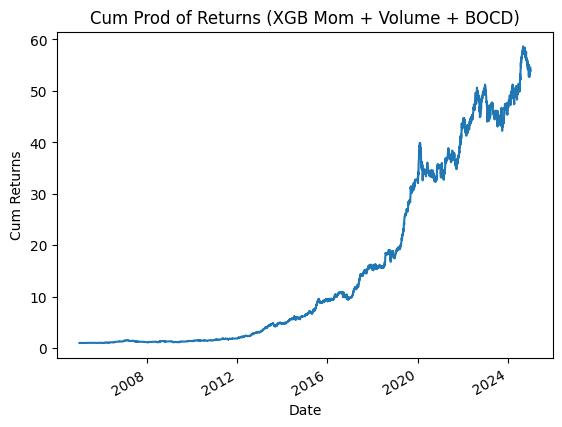

In [15]:
import matplotlib.pyplot as plt
(1 + pnl).cumprod().plot()
plt.title("Cum Prod of Returns (XGB Mom + Volume + BOCD)")
plt.xlabel('Date')
plt.ylabel('Cum Returns')

Text(0, 0.5, 'Cum Returns')

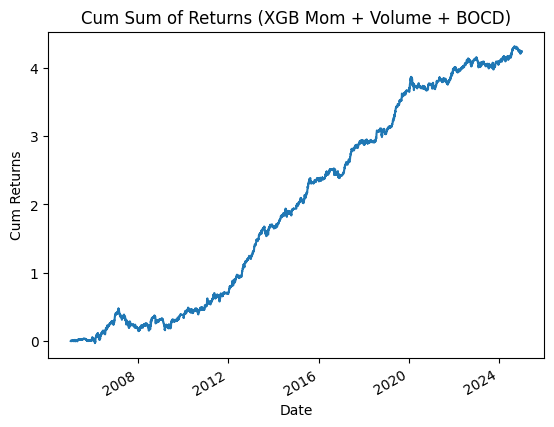

In [16]:
pnl.cumsum().plot()
plt.title("Cum Sum of Returns (XGB Mom + Volume + BOCD)")
plt.xlabel('Date')
plt.ylabel('Cum Returns')